[EN]
# Training a Neural Network

In this LAB, you'll train a compact convolutional neural network (CNN) on CIFAR-10 dataset, explore different optimizers, test normalization and dropout strategies, and see how data augmentation changes model performance.

By the end of this LAB you should be able to:

* Build and train a small CNN with PyTorch.

* Explain differences between common optimizers (SGD, Momentum, Adam, RMSProp, AdaGrad).

* Understand the benefits of regularization techniques, such as normalization and Dropout.

* Implement and test simple data augmentations and measure their effect.

To use this notebook, just run cells sequentially.

[VN]
# Hu·∫•n luy·ªán m·ªôt m·∫°ng n∆° ron

Trong bu·ªïi th·ª±c h√†nh, ta s·∫Ω hu·∫•n luy·ªán m·ªôt m·∫°ng n∆° ron t√≠ch ch·∫≠p nh·ªè (CNN) tr√™n b·ªô d·ªØ li·ªáu CIFAR-10, kh√°m ph√° c√°c b·ªô t·ªëi ∆∞u kh√°c nhau, ki·ªÉm tra s·ª± chu·∫©n ho√° v√† c√°c chi·∫øn l∆∞·ª£c b·ªè-qu√™n (dropout), v√† xem x√©t l√†m sao d·ªØ li·ªáu tƒÉng c∆∞·ªùng s·∫Ω thay ƒë·ªïi hi·ªáu qu·∫£ c·ªßa m√¥ h√¨nh.

K·∫øt th√∫c bu·ªïi th·ª±c h√†nh, ta c√≥ th·ªÉ th·ª±c hi·ªán

* X√¢y d·ª±ng v√† hu·∫•n luy·ªán m·ªôt m·∫°ng n∆° ron nh·ªè trong PyTorch

* Gi·∫£i th√≠ch ƒë∆∞·ª£c s·ª± kh√°c bi·ªát gi·ªØa c√°c b·ªô t·ªëi ∆∞u ph·ªï bi·∫øn (SGD, Momentum, Adam, RMSProp, AdaGrad).

* Hi·ªÅu ƒë∆∞·ª£c l·ª£i √≠ch c·ªßa c√°c k·ªπ thu·∫≠t ch·ªëng h·ªçc qu√° nh∆∞ chu·∫©n ho√° hay b·ªè-qu√™n.

* C√†i ƒë·∫∑t v√† ki·ªÉm tra d·ªØ li·ªáu tƒÉng c∆∞·ªùng v√† ƒëo s·ª± hi·ªáu qu·∫£ c·ªßa n√≥

ƒê·ªÉ d√πng s·ªï tay n√†y, ch·ªâ c·∫ßn ch·∫°y c√°c √¥ m√£ ngu·ªìn m·ªôt c√°ch tu·∫ßn t·ª±

## Setup and imports


In [ ]:
# Standard imports and environment setup
import os, time, copy, random
from pathlib import Path
from typing import Dict, Any, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

# reproducibility
RND_SEED = 42
random.seed(RND_SEED)
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)

# device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# output directory
OUT_DIR = Path('cnn_practice_out')
OUT_DIR.mkdir(exist_ok=True)


Device: cuda


[EN]
## Model architecture

In this section, we'll define a simple CNN for image classification. This network consists of convolutional layers and a classification head, which is a fully-connected neural network. Now, your task is to implement a class `SmallCNN` given the architecture in the image. Here are some additional details:
* The padding and stride of every convolutional layer is 1.

* The kernel size of each convolutional layer is 3.

* The kernel size of each `MaxPool` layer is 2.

* The penultimate layer of the classification head uses `ReLU` as the activation function.

* The output layer uses  the `softmax` as activation function

[VN]
## Ki·∫øn tr√∫c m√¥ h√¨nh

Trong ph·∫ßn n√†y, ta s·∫Ω ƒë·ªãnh nghƒ©a m·ªôt m·∫°ng n∆° ron t√≠ch ch·∫≠p ƒë∆°n gi·∫£n d√†nh cho b√†i to√°n ph√¢n lo·∫°i h√¨nh ·∫£nh. M·∫°ng n∆° ron n√†y bao g·ªìm c√°c t·∫ßng t√≠ch ch·∫≠p v√† m·ªôt ƒë·∫ßu ph√¢n lo·∫°i v·ªën l√† l·ªõp m·∫°ng n∆° ron k·∫øt n·ªëi ƒë·∫ßy ƒë·ªß. B√¢y gi·ªù, c√¥ng vi·ªác c·ªßa b·∫°n l√† c√†i ƒë·∫∑t l·ªõp `SmallCNN` c√≥ ki·∫øn tr√∫c ƒë∆∞·ª£c minh ho·∫° d∆∞·ªõi ƒë√¢y. Ngo√†i ra c√≤n c√≥ c√°c th√¥ng tin b·ªï sung nh∆∞ sau :

* C√°c vi·ªÅn v√† b∆∞·ªõc nh·∫©y c·ªßa c√°c t·∫ßng t√≠ch ch·∫≠p ƒë·ªÅu l√† 1

* K√≠ch th∆∞·ªõc nh√¢n c·ªßa c√°c t·∫ßng t√≠ch ch·∫≠p ƒë·ªÅu l√† 3

* K√≠ch th∆∞·ªõc nh√¢n c·ªßa c√°c t·∫ßng gi·∫£m m·∫´u `MaxPool` l√† 2

* C√°c l·ªõp tr∆∞·ªõc ƒë·∫ßu ra ph√¢n lo·∫°i ƒë·ªÅu d√πng h√†m k√≠ch ho·∫°t `ReLU`

* L·ªõp ƒë·∫ßu ra d√πng h√†m ƒë·∫ßu ra `softmax`

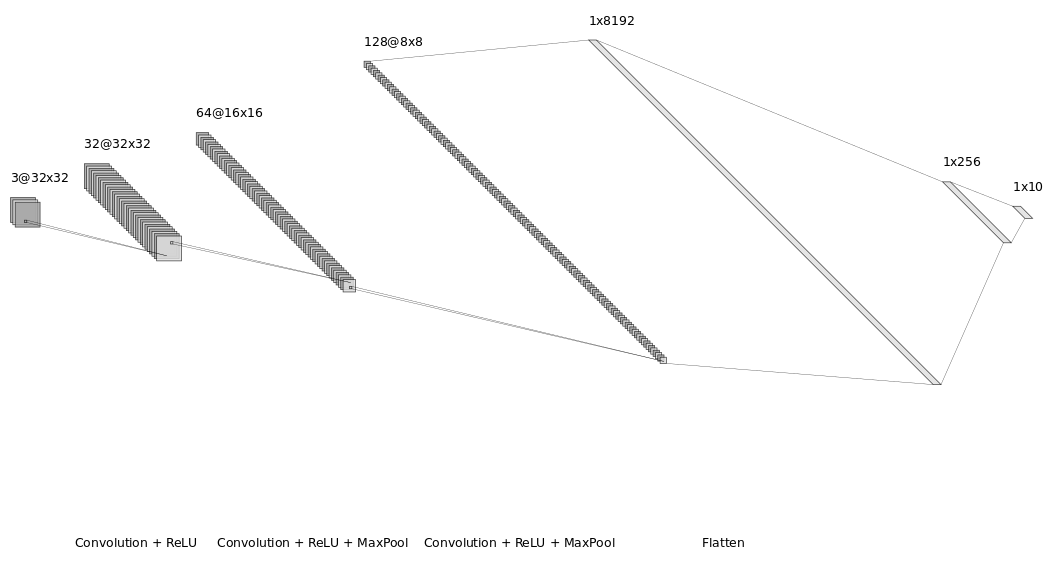
---
[EN] The abbreviation D@HxW means respectively depth, high, and width sizes of  the convolutional layer.

[VN] Vi·∫øt t·∫Øt D@HxW nghƒ©a l√† c√°c k√≠ch th∆∞·ªõc ƒë·ªô s√¢u, cao v√† r·ªông c·ªßa l·ªõp n∆° ron t√≠ch ch·∫≠p.
```



In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        ## TODO: your implementation here

    def forward(self, x):
        ## TODO: your implementation here


[EN]
## The CIFAR-10 dataset
The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The CIFAR-10 dataset contains 60K of 32x32 color images in 10 different classes that are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6K images of each class. For the dataset loading, it's able to   

* Normalize color histogram

* Transform into tensor

[VN]
## B·ªô d·ªØ li·ªáu CIFAR-10
B·ªô d·ªØ li·ªáu CIFAR-10 l√† m·ªôt b·ªô ·∫£nh th∆∞·ªùng d√πng cho hu·∫•n luy·ªán gi·∫£i thu·∫≠t h·ªçc m√°y v√† th·ªã gi√°c m√°y t√≠nh. B·ªô d·ªØ li·ªáu CIFAR-10 ch·ª©a 60K ·∫£nh m·∫ßu k√≠ch th∆∞·ªõc 32x32 g√°n 10 l·ªõp nh√£n ch√∫ng l√† m√°y bay, √¥ t√¥, chim, m√®o, h∆∞∆°u, ch√≥, ·∫øch, m√°y bay, t·∫ßu v√† xe t·∫£i. C√≥ 6K ·∫£nh t∆∞∆°ng ·ª©ng m·ªói l·ªõp. ƒê·ªÉ t√†i b·ªô d·ªØ li√™u, ta c√¢n c√≥

* Chu·∫©n ho√° m·∫ßu ·∫£nh

* Chuy·ªÉn sang tensor


In [ ]:
def get_dataloaders(dataset_name: str = 'CIFAR10', batch_size: int = 128, quick: bool = False):
    if dataset_name.upper() == 'CIFAR10':

        # Normalize the same as ImageNet

        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2470, 0.2435, 0.2616)

        train_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        root = './data'
        train_set = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=train_transforms)
        test_set = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=test_transforms)
        num_classes = 10

    else:
        raise ValueError('Unsupported dataset')

    if quick:
        # Small subset for demonstration
        if hasattr(train_set, 'data'):
            train_set.data = train_set.data[:2000]
        if hasattr(train_set, 'targets'):
            train_set.targets = train_set.targets[:2000]
        if hasattr(test_set, 'data'):
            test_set.data = test_set.data[:1000]
        if hasattr(test_set, 'targets'):
            test_set.targets = test_set.targets[:1000]

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader, num_classes


[EN]

## Training
Here are the implementation of 2 function `train_one_epoch` and `evaluate`, which are used for training and evaluation. In PyTorch, for almost all models, the training procedure consists of the following key steps:

- Move inputs and targets to the same device as the model (GPU).
- Zero optimizer gradients (`optimizer.zero_grad()`). If you forget to call this function, gradients will accumulate across iterations.
- Compute the loss and backpropagate (via `loss.backward()`).
- Update weights based on the current weights and the computed gradients (`optimizer.step()`).

[VN]
## Hu·∫•n luy·ªán
ƒê√¢y l√† ph·∫ßn c√†i ƒë·∫∑t c·ªßa hai h√†m `train_one_epoch` v√† `evaluate`, ch√∫ng ƒë∆∞·ª£c d√πng cho pha hu·∫•n luy·ªán v√† ƒë√°nh gi√°. Trong PyTorch, v·ªõi h·∫ßu h·∫øt c√°c m√¥ h√¨nh, th·ªß t·ª•c hu·∫•n luy·ªán bao g·ªìm c√°c b∆∞·ªõc quan tr·ªçng nh∆∞ sau :

- Chuy·ªÉn d·ªØ li·ªáu ƒë·∫ßu v√†o, ƒë√≠ch ƒë·∫øn c√πng m√¥ h√¨nh ƒë·∫øn thi·∫øt b·ªã t√≠nh to√°n (th∆∞·ªùng l√† GPU)
- X√°c l·∫≠p ƒë·∫°o h√†m (gradients) c·ªßa b·ªô t·ªëi ∆∞u v·ªÅ kh√¥ng (`optimizer.zero_grad()`). N·∫øu ta mu·ªën g·ªçi h√†m n√†y, ƒë·∫°o h√†m s·∫Ω ƒë∆∞·ª£c t·ªïng h·ª£p theo t·ª´ng v√≤ng l·∫∑p.
- T√≠nh to√°n l·ªói v√† lan truy·ªÅn ng∆∞·ª£c (b·∫±ng c√°ch `loss.backward()`).
- T√≠nh to√°n ƒë·∫°o h√†m v√† c·∫≠p nh·∫≠t tr·ªçng s·ªë hi·ªán t·∫°i (b·∫±ng c√°ch `optimizer.step()`).  



In [ ]:
# Training and evaluation loops
def train_one_epoch(model: nn.Module, loader, criterion, optimizer, device: torch.device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        _, preds = out.max(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss / total, correct / total

def evaluate(model: nn.Module, loader, criterion, device: torch.device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            _, preds = out.max(1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return running_loss / total, correct / total


[EN]

Now, let's train our model for 10 epochs, using an SGD optimizer.

[VN]

B√¢y gi·ªù, h√£y hu·∫•n luy·ªán m√¥ h√¨nh v·ªõi 10 v√≤ng l·∫∑p, s·ª≠ d·ª•ng b·ªô t·ªëi ∆∞u SGD

In [ ]:
num_epochs = 10

train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
model = SmallCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_params, lr=1e-3)

best_val_acc = 0.0
best_model = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())

    if verbose:
        print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")

[EN]

Saving the best checkpoint

[VN]

Sao l∆∞u l·∫°i m√¥ h√¨nh t·ªët nh·∫•t



In [ ]:
model_path = OUT_DIR / "demo_SGD.pth"
if best_model is not None:
    torch.save(best_model, model_path)

[EN]
## Optimizer selection

Switching the optimizer can dramatically change training dynamics. This section runs the same model with different optimizers and plots training loss and validation accuracy across epochs.

Now, your task is to implement some optimizers, namely SGD (with / without momentum), Adagrad, RMSprop and Adam. Additionally, you can take a look at torch.optim documentation link for more optimizers.

[VN]
## L·ª±a ch·ªçn b·ªô t·ªëi ∆∞u

Thay ƒë·ªïi l·ª±a ch·ªçn b·ªô t·ªëi ∆∞u c√≥ th·ªÉ g√¢y s·ª± thay ƒë·ªïi l·ªõn khi hu·∫•n luy·ªán. Ph·∫ßn ti·∫øp theo ta s·∫Ω ch·∫°y m·ªôt m√¥ h√¨nh v·ªõi nhi·ªÅu b·ªô t·ªëi ∆∞u kh√°c nhau v√† v·∫Ω c√°c h√†m m·∫•t m√°t v√† th·ª±c hi·ªán ƒë√°nh gi√° ch√©o t·∫°i m·ªói v√≤ng l·∫∑p.

Nhi·ªám v·ª• b√¢y gi·ªù l√† c√†i ƒë·∫∑t c√°c b·ªô t·ªëi ∆∞u  SGD (c√≥ / kh√¥ng c√≥ momentum), Adagrad, RMSprop v√† Adam. Ta c·∫ßn ƒë·ªçc th√™m h∆∞·ªõng d·∫´n torch.optim ƒë·ªÉ hi·ªÉu th√™m c√°c tham s·ªë c·ªßa c√°c b·ªô t·ªëi ∆∞u.






In [ ]:
# Optimizer factory
def get_optimizer(name: str, model_params, lr: float = 1e-3, momentum: float = 0.9, weight_decay: float = 0.0):
    name = name.lower()
    if name == 'sgd':
        ## TODO: your implementation here
    elif name == 'sgd_momentum':
        ## TODO: your implementation here
    elif name == 'adagrad':
        ## TODO: your implementation here
    elif name == 'rmsprop':
        ## TODO: your implementation here
    elif name == 'adam':
        ## TODO: your implementation here
    else:
        raise ValueError(f"Unknown optimizer: {name}")


In [ ]:
# Helper function for running experiment
def optimizer_run_experiment(
    exp_name: str,
    optimizer_name: str,
    lr: float,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
    model = SmallCNN(num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")


    # save results
    out = {
        'exp_name': exp_name,
        'optimizer': optimizer_name,
        'lr': lr,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def optimizer_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = optimizer_run_experiment(
            exp_name=name,
            optimizer_name=cfg.get('optimizer', 'adam'),
            lr=cfg.get('lr', 1e-3),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['optimizer']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[EN]

Training our model with different optimizers

[VN]

Hu·∫•n luy·ªán m√¥ h√¨nh v·ªõi nhi·ªÅu b·ªô t·ªëi ∆∞u


Running 1/5: opt_sgd
[opt_sgd] Epoch 1/50 | train loss 2.3024 acc 0.1045 | val loss 2.3022 acc 0.0960 | time 0.9s
[opt_sgd] Epoch 2/50 | train loss 2.3022 acc 0.1075 | val loss 2.3021 acc 0.0970 | time 0.9s
[opt_sgd] Epoch 3/50 | train loss 2.3020 acc 0.1090 | val loss 2.3019 acc 0.1020 | time 0.8s
[opt_sgd] Epoch 4/50 | train loss 2.3018 acc 0.1125 | val loss 2.3017 acc 0.1040 | time 0.9s
[opt_sgd] Epoch 5/50 | train loss 2.3016 acc 0.1150 | val loss 2.3015 acc 0.1040 | time 0.9s
[opt_sgd] Epoch 6/50 | train loss 2.3013 acc 0.1135 | val loss 2.3013 acc 0.1080 | time 0.9s
[opt_sgd] Epoch 7/50 | train loss 2.3012 acc 0.1200 | val loss 2.3011 acc 0.1080 | time 1.1s
[opt_sgd] Epoch 8/50 | train loss 2.3010 acc 0.1225 | val loss 2.3009 acc 0.1160 | time 1.4s
[opt_sgd] Epoch 9/50 | train loss 2.3008 acc 0.1280 | val loss 2.3008 acc 0.1190 | time 1.3s
[opt_sgd] Epoch 10/50 | train loss 2.3006 acc 0.1355 | val loss 2.3006 acc 0.1260 | time 1.2s
[opt_sgd] Epoch 11/50 | train loss 2.3004 acc 0.

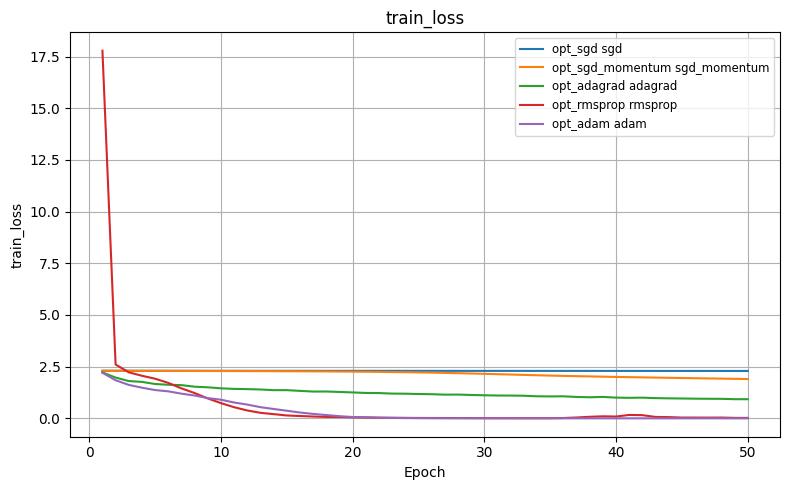

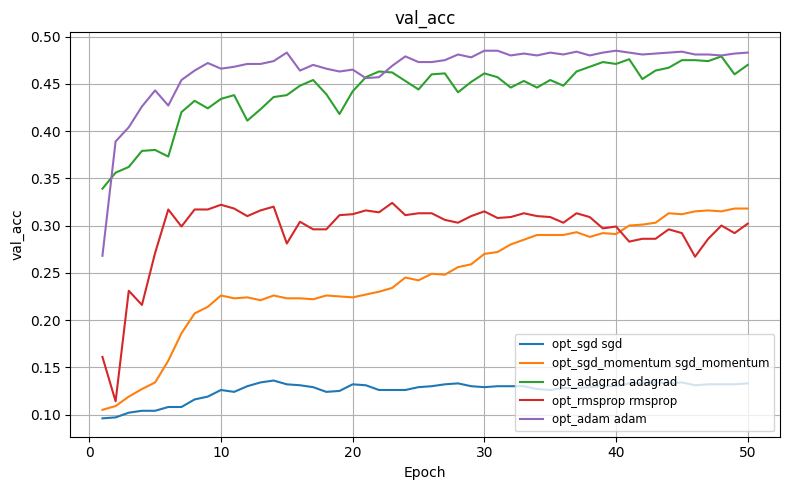

In [ ]:
quick_debug = True
num_epochs = 50

base_lr = 1e-3
exps = []

## Add any optimizer that you want to try here.
optimizers = []

for opt in optimizers:
      exps.append({
          'name': f"opt_{opt}",
          'optimizer': opt,
          'lr': base_lr,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = optimizer_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'optimizer_results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'optimizer', 'lr', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['optimizer'], r['lr'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot train loss validation accuracies
plot_history(results, key='train_loss')
plot_history(results, key='val_acc')


[EN]

## Normalization technique selection

Normalization layers can help stabilize and speed up training. In this section you will train identical networks with BatchNorm, InstanceNorm, GroupNorm and no normalization to compare their training convergence speed and validation accuracy.

Let's define a function `norm_layer(channels)`. This functions takes `channels`, which is the number of channels of the input tensor, as the input, and output a normalization layer.

[VN]

## L·ª±a ch·ªçn k·ªπ thu·∫≠t chu·∫©n ho√°

C√°c l·ªõp chu·∫©n ho√° cho ph√©p ·ªïn ƒë·ªãnh v√† tƒÉng t·ªëc qu√° tr√¨nh hu·∫•n luy·ªán. Trong ph·∫ßn n√†y, ta s·∫Ω hu·∫•n luy·ªán c√°c m·∫°ng n∆° ron c√≥ chu·∫©n ho√° (theo b√≥, theo m·∫´u, theo nh√≥m) v√† so s√°nh kh√¥ng chu·∫©n ho√° v·ªõi ti√™u ch√≠ t·ªëc ƒë·ªô h·ªôi t·ª• v√† ƒë·ªô ch√≠nh x√°c tr√™n t·∫≠p ƒë√°nh gi√°.

H√£y ƒë·ªãnh nghƒ©a h√†m `norm_layer(channels)` v·ªõi tham s·ªë ƒë·∫ßu v√†o `channels` l√† s·ªë k√™nh c·ªßa tensor ƒë·∫ßu v√†o, c√≤n ƒë·∫ßu ra c·ªßa h√†m l√† l·ªõp ƒë√£ chu·∫©n ho√°.



In [ ]:
class SmallCNNWithNormalization(nn.Module):
    def __init__(self, norm=None, num_classes=10):

        super().__init__()
        self.norm = norm

        def norm_layer(channels):
            # Feel free to add as many normalization techniques as you want!
            if norm is None:
                ## TODO: your implementation here
            elif norm == 'batch':
                ## TODO: your implementation here
            elif norm == 'instance':
                ## TODO: your implementation here
            elif norm == 'group':
                ## TODO: your implementation here
            else:
                raise ValueError("The normalization technique is not supported")

        # Copy your implementation of SmallCNN here. Make sure to add norm_layer to your architecture.

    def forward(self, x):
        # Copy your implementation of SmallCNN here

In [ ]:
# Helper function for running experiments
def normalization_run_experiment(
    exp_name: str,
    norm: str | None,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
    model = SmallCNNWithNormalization(num_classes=num_classes, norm=norm).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), lr=1e-3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")


    # save results
    out = {
        'exp_name': exp_name,
        'norm': norm,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def normalization_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = normalization_run_experiment(
            exp_name=name,
            norm=cfg.get('norm', None),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['norm']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[EN]

Let's try some normalization techniques that you've just implemented.

[VN]

H√£y th·ª≠ m·ªôt v√†i k·ªπ thu·∫≠t chu·∫©n ho√° m√† ta v·ª´a c√†i ƒë·∫∑t

In [ ]:
quick_debug = True
num_epochs = 50

exps = []

## Add any normalization technique that you want to try here.
norms = [None]

for norm in norms:
      exps.append({
          'name': f"norm_{norm}",
          'norm': norm,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = normalization_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'normalization_results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'norm', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['norm'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot validation accuracies
plot_history(results, key='train_loss')
plot_history(results, key='val_acc')


[EN]

## Dropout

Dropout randomly zeros activations during training to reduce co-adaptation of neurons and to regularize models. This section sweeps through dropout probabilities and shows how validation accuracy changes.


[VN]

## B·ªè-m·∫∑c

K·ªπ thu·∫≠t b·ªè-m·∫∑c s·∫Ω kh√¥ng k√≠ch ho·∫°t m·ªôt c√°ch ng·∫´u nhi√™n c√°c n∆° ron trong qu√° tr√¨nh hu·∫•n luy·ªán ƒë·ªÉ gi·∫£m thi·ªÉu t√≠nh ƒë·ªìng-t∆∞∆°ng th√≠ch v√† tƒÉng t√≠nh ƒëi·ªÅu ph·ªëi trong m√¥ h√¨nh. Trong ph·∫ßn n√†y ta s·∫Ω thay ƒë·ªïi t·ª∑ l·ªá x√°c su·∫•t k·ªπ thu·∫≠t b·ªï-m·∫∑c v√† s·ª± thay ƒë·ªïi t·ª∑ l·ªá ch√≠nh x√°c trong t·∫≠p ƒë√°nh gi√°.

In [ ]:
class SmallCNNWithNormalizationAndDropout(nn.Module):
    def __init__(self, norm=None, dropout_p=0.0, num_classes=10):

        super().__init__()
        self.norm = norm
        self.dropout_p = dropout_p

        def norm_layer(channels):
            ## Copy your norm_layer implementation here.

        # Copy your implementation of SmallCNNWithNormalization here. Add dropout layers wherever you want.

    def forward(self, x):
        # Copy your implementation of SmallCNNWithNormalization here.

In [ ]:
# Helper function for running experiments
def dropout_run_experiment(
    exp_name: str,
    dropout_p: float,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
    model = SmallCNNWithNormalizationAndDropout(num_classes=num_classes, norm='batch', dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), lr=1e-3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")

    # save results
    out = {
        'exp_name': exp_name,
        'dropout_p': norm,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def dropout_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = dropout_run_experiment(
            exp_name=name,
            dropout_p=cfg.get('dropout_p', 0.0),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['dropout_p']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
quick_debug = True
num_epochs = 50

exps = []
# Add any dropout probability that you want here
dropout_p_list = []

for dropout_p in dropout_p_list:
      exps.append({
          'name': f"dropout_{dropout_p}",
          'dropout_p': dropout_p,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = dropout_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'dropout_results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'dropout_p', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['dropout_p'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot validation accuracies
plot_history(results, key='val_acc')


[EN]

## Data augmentation

Data augmentation increases training dataset diversity on the fly, and is known to reduce overfitting. Let's go back to the helper function to load the CIFAR-10 dataset and add data augmentation there. In this part, we will use [`RandomCrop`](https://docs.pytorch.org/vision/0.22/generated/torchvision.transforms.RandomCrop.html) and [`RandomHorizontalFlip`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) for augmentation.

[VN]

## TƒÉng c∆∞·ªùng d·ªØ li·ªáu

TƒÉng c∆∞·ªùng d·ªØ li·ªáu l√†m tƒÉng t√≠nh ƒëa d·∫°ng c·ªßa t·∫≠p d·ªØ li·ªáu hu·∫•n luy·ªán, v√† c≈©ng ƒë∆∞·ª£c bi·∫øt ƒë·∫øn nh∆∞ c√°ch l√†m gi·∫£m v·∫•n ƒë·ªÅ qu√° kh·ªõp. Quay l·∫°i v·ªõi h√†m d√πng ƒë·ªÉ t·∫£i d·ªØ li·ªáu CIFAR-10 v√† b·ªï sung k·ªπ thu·∫≠t tƒÉng c∆∞·ªùng d·ªØ li·ªáu t·∫°i ƒë√¢y. Trong ph·∫ßn n√†y, ta s·∫Ω d√πng hai k·ªπ thu·∫≠t [`RandomCrop`](https://docs.pytorch.org/vision/0.22/generated/torchvision.transforms.RandomCrop.html) v√† [`RandomHorizontalFlip`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html)




In [ ]:
def get_dataloaders(dataset_name: str = 'CIFAR10', use_augmentation=False, batch_size: int = 128, quick: bool = False):
    """Return train and test dataloaders and number of classes.
    quick: if True, uses smaller subsets for faster debugging.
    """
    if dataset_name.upper() == 'CIFAR10':

        # Normalize the same as ImageNet

        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2470, 0.2435, 0.2616)

        if use_augmentation:
            train_transforms = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        else:
            train_transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        root = './data'
        train_set = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=train_transforms)
        test_set = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=test_transforms)
        num_classes = 10

    else:
        raise ValueError('Unsupported dataset')

    if quick:
        # Small subset for debugging
        if hasattr(train_set, 'data'):
            train_set.data = train_set.data[:2000]
        if hasattr(train_set, 'targets'):
            train_set.targets = train_set.targets[:2000]
        if hasattr(test_set, 'data'):
            test_set.data = test_set.data[:1000]
        if hasattr(test_set, 'targets'):
            test_set.targets = test_set.targets[:1000]

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader, num_classes


In [ ]:
# Helper function for running experiments
def augmentation_run_experiment(
    exp_name: str,
    use_augmentation: bool,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', use_augmentation=use_augmentation, batch_size=batch_size, quick=quick)
    model = SmallCNN(num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), lr=1e-3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")


    # save results
    out = {
        'exp_name': exp_name,
        'use_augmentation': use_augmentation,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def augmentation_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = augmentation_run_experiment(
            exp_name=name,
            use_augmentation=cfg.get('use_augmentation', False),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['use_augmentation']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[EN]

Let's see if data augmentation really works ü§î

[VN]

Ki·ªÉm tra xem k·ªπ thu·∫≠t tƒÉng c∆∞·ªùng d·ªØ li·ªáu ho·∫°t ƒë·ªông t·ªët ü§î

In [ ]:
# Running the experiment
quick_debug = True
num_epochs = 50

use_augmentation_list = [False, True]

exps = []

for use_augmentation in use_augmentation_list:
      exps.append({
          'name': f"augmentation_{use_augmentation}",
          'use_augmentation': use_augmentation,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = augmentation_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'use_augmentation', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['use_augmentation'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot validation accuracies
plot_history(results, key='train_loss')
plot_history(results, key='val_acc')


[EN]

**Question:** Which augmentations might harm performance on CIFAR-10 ? Why?

[VN]

**C√¢u h·ªèi:** K·ªπ thu·∫≠t tƒÉng c∆∞·ªùng n√†o c√≥ th·ªÉ ·∫£nh h∆∞·ªùng kh√¥ng t·ªët ƒë·∫øn hi·ªáu qu·∫£ m√¥ h√¨nh tr√™n b·ªô d·ªØ li·ªáu CIFAR-10 ? V√¨ sao ?

[EN]

## Final suggestions
If you finished early, feel free to try these:
* Replace the simple CNN with a ResNet-like block and measure the performance difference.

* Implement weight decay sweeps and observe how regularization differs from dropout.

* Play with another dataset (such as MNIST, ImageNet)


[VN]

## C√°c khuy·∫øn ngh·ªã cu·ªëi c√πng

N·∫øu b·∫°n th·ª±c hi·ªán xong s·ªõm, c√≥ th·ªÉ th·ª≠ th√™m c√°c th√≠ nghi·ªám kh√°c :

* Thay m·∫°ng t√≠ch ch·∫≠p ƒë∆°n gi·∫£n b·∫±ng m·∫°ng kh·ªëi gi·ªëng ResNet v√† ƒëo t√≠nh hi·ªáu qu·∫£ c·ªßa n√≥

* C√†i ƒë·∫∑t suy gi·∫£m tr·ªçng s·ªë v√† quan s√°t xem n√≥ ƒëi·ªÅu ph·ªëi kh√°c g√¨ so v·ªõi k·ªπ thu·∫≠t b·ªè-m·∫∑c

* Th·ª±c nghi·ªám v·ªõi c√°c b·ªô d·ªØ li·ªáu kh√°c nh∆∞ MNIST, ImageNet






